## 1. Background
The body fat percentage (BFP) of a human is the total mass of fat divided by total body mass, multiplied by 100.

Body fat is a measure of obesity, plays an important role in various health outcomes such as life expectancy, prognosis for disease, healthcare costs, and the general well-being of individuals. 

Current measurement technique including underwater weighing, Whole-body air displacement plethysmography (ADP), Dual energy X-ray absorptiometry are usually inconvenient/costly.

A simple, robust, accurate and precise  “rule-of-thumb” method to estimate percentage of body fat using clinically available measurements is in need.

Our analysis and model is based on a real data set of 252 men with measurements of their percentage of body fat and various body circumference measurements.

## 2. Data Cleaning 

The first thing to check is whether there are any apparently wrong records. According to Siri's equation, there is a linear relation between the percentage of body fat and the reciprocal of density, so we draw the following plot (1/DENSITY vs. BODYFAT).

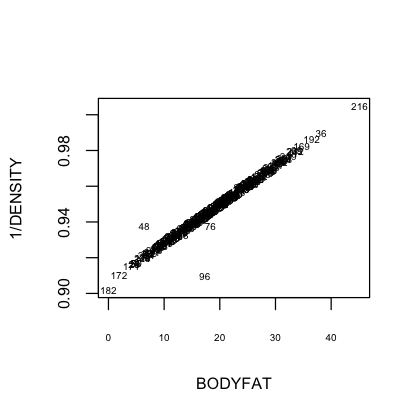

In [1]:
bodyfat <- read.table('../data/BodyFat.csv',header = T,sep = ',')
options(repr.plot.width=3.5, repr.plot.height=3.5);par(cex.lab=0.8)
plot(bodyfat$BODYFAT,1/bodyfat$DENSITY,type = 'n',xlab="BODYFAT",ylab="1/DENSITY",xaxt="n",yaxt="n");axis(1,cex.axis=0.5);axis(2,cex.axis=0.8)
text(bodyfat$BODYFAT,1/bodyfat$DENSITY,bodyfat$IDNO,cex=0.5)

The 182th, 96th, 76th and 48th records should be dropped since we can't decide if we should believe BODYFAT or DENSITY or neither. According to the BMI equation (BMI=Weight/Height^2), similarly, we draw the following plots to find anomalies (WEIGHT/HEIGHT^2 vs. ADIPOSITY). In order to make a clearer display, the plot on the left includes 42th record, and the one on the right excludes it.

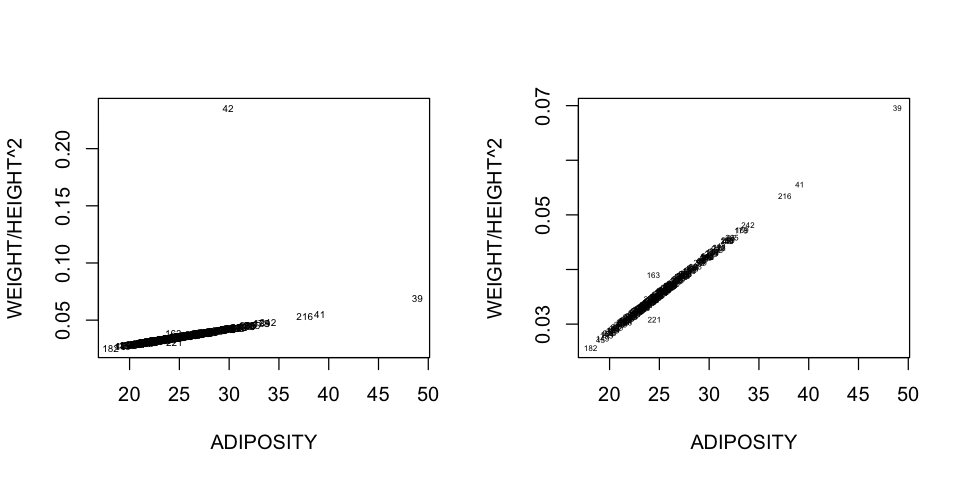

In [2]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,bodyfat$IDNO,cex=0.5)
plot(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,bodyfat[-42,]$IDNO,cex=0.4)

We can see that No. 42, 163 and 221 are far away from the theoretical line. We correct the mistakes using their weight and adiposity. For 39th and 41th records, they are far away from the majority, we need further study (which will be discussed later) to decide whether they are valid or not.

In [3]:
bodyfat[42,'HEIGHT'] <- sqrt(bodyfat[42,'WEIGHT']/bodyfat[42,'ADIPOSITY']*703)
bodyfat[162,'HEIGHT'] <- sqrt(bodyfat[162,'WEIGHT']/bodyfat[162,'ADIPOSITY']*703) 
bodyfat[220,'HEIGHT'] <- sqrt(bodyfat[220,'WEIGHT']/bodyfat[220,'ADIPOSITY']*703) 

We then check whether there are any unusual values of the response (i.e. BODYFAT). Judged from the quartiles and the boxplot, there are two skeptical records (No. 172 and 216). Their bodyfat are 1.9$\%$ and 45.1$\%$. According to American Council on Exercise, the minimum bodyfat is about 2$\%$. 45.1$\%$ is a possible value based on our research. Therefore, we keep both of them. 

Next, we detect outliers for explanatory variables. Intuitively, if some record is far from the majority, it may be wrong. Even it is a correct record, it may not come from the same population we are interested in. It is difficult to plot high dimension scatter plot so here we look at pairwise scatter plots. Here, we just take the first 5 variables to illustrate how we detect.

In [7]:
require("MVA")
require("biwt")

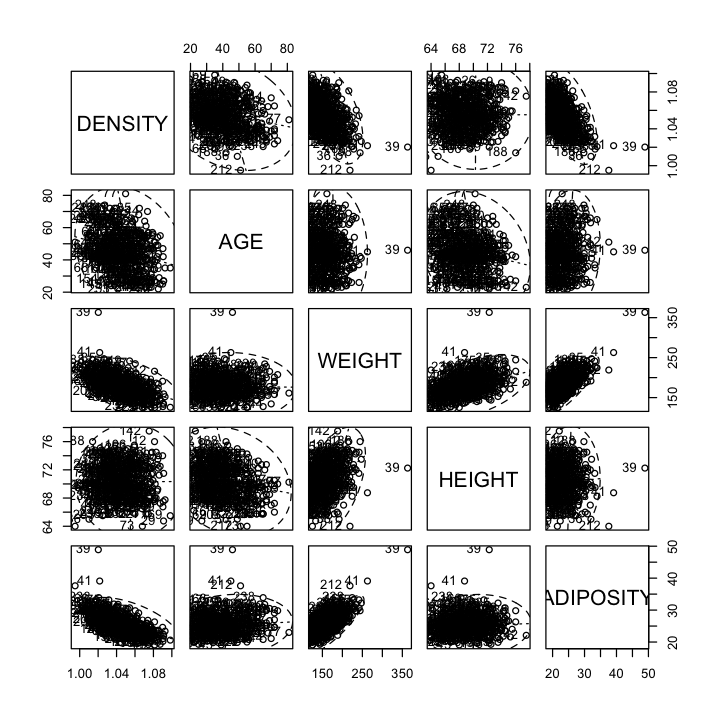

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
pairs(bodyfat[-c(48,76,96,182),3:7], 
      panel = function(x,y, ...) {
        text(x, y, bodyfat$IDNO,cex = 1, pos = 2)
        bvbox(cbind(x,y), add = TRUE,method = "robust")
      })

The 39, 41 and 212 always lay out of the dashed line. We adapt star plots to check if there is any mistake.

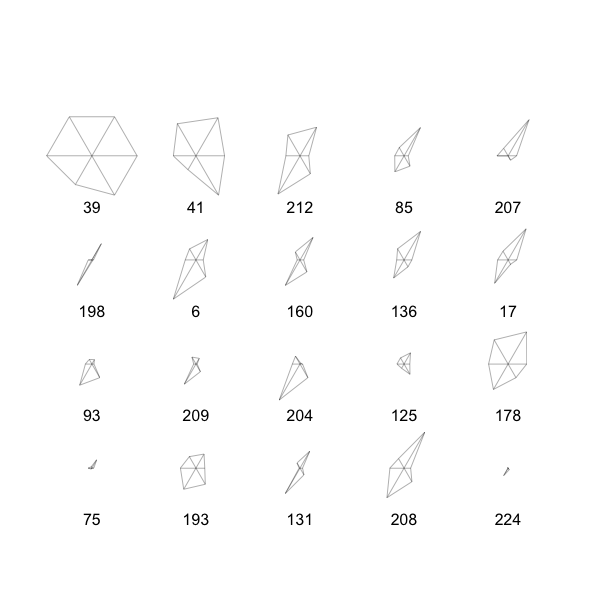

In [9]:
set.seed(2)
x <- sample(1:252,18)
y <- x[!x %in% c(48,76,96,182)]
options(repr.plot.width=5, repr.plot.height=5)
subdata <- bodyfat[unique(c(39,41,212,y)),c('IDNO',"ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')]
stars(subdata[,c("ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')],
      nrow=5,ncol=5,labels=subdata$IDNO)

The first 3 hexagon are the suspects, the vertexes of hexagon represent a man's ADIPOSITY, BODYFAT, CHEST, NECK, HEIGHT and WRIST. We can see 39 and 41 are two big guys with large measurements in almost every aspect and are significantly different from others, so we delete them. 212 has a similar 'shape' with most of other people so we think it is a valid record. Besides, we check the extreme values for each variables, they are among the reasonable range, so we keep them all.

So far, we have deleted No.39, 41, 48, 76, 96, 182 records. Next, we fit a full linear regression model to make further inspection. Judged from the residual plots, there are no obvious outliers any more, but high-leverage points exist. Then we detect influential observations by cook's distance and leverage. (The red lines are thresholds based on rules of thumb.)

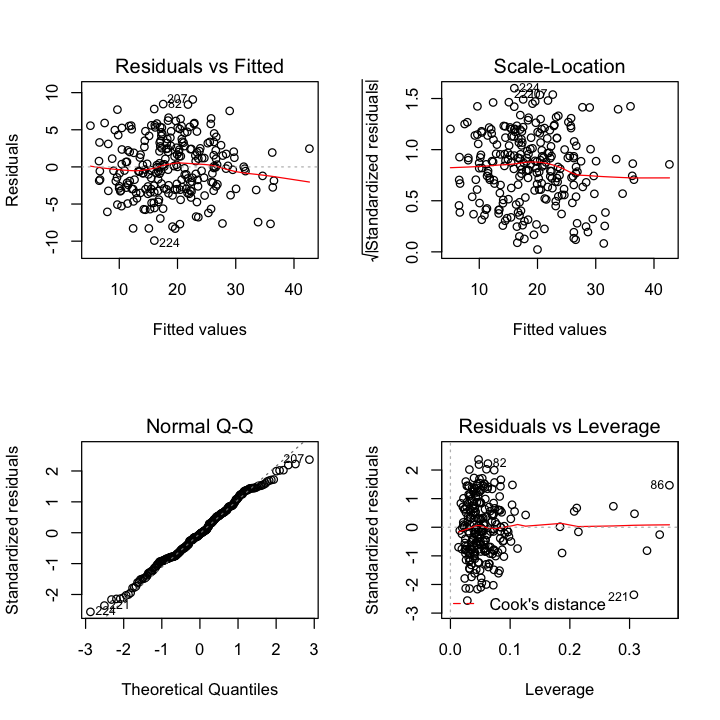

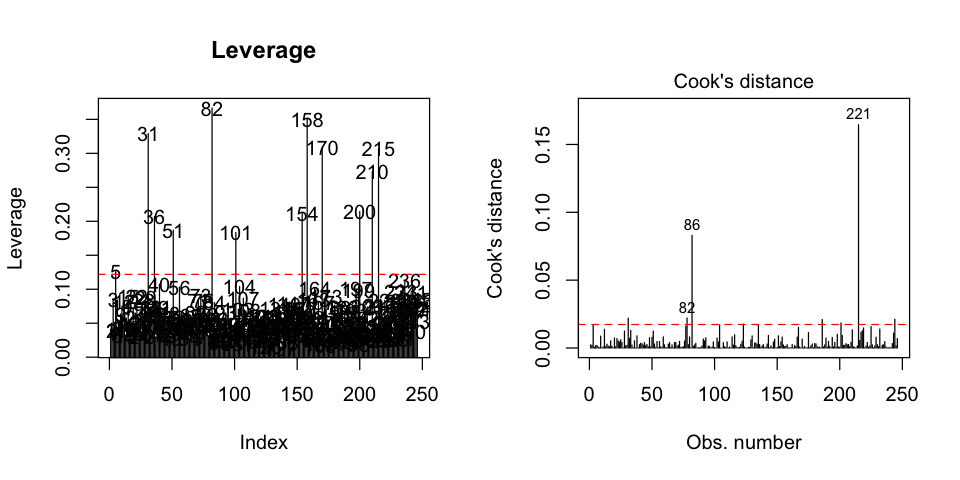

In [10]:
options(repr.plot.width=6, repr.plot.height=6)
bodyfat$IDNO=NULL
lm.dirte <- lm(BODYFAT ~ ., data=subset(bodyfat[-c(39,41,48,76,96,182),],select=-DENSITY))
par(mfcol=c(2,2))
plot(lm.dirte)
options(repr.plot.width=8, repr.plot.height=4)
par(mfcol=c(1,2))
lm.dirte.hats = hatvalues(lm.dirte)
plot(lm.dirte.hats, type = "h", ylab = "Leverage",main="Leverage") 
text(lm.dirte.hats, cex = 1)
abline(h=2*15/(252-6), lty = 2,col=2) 
plot(lm.dirte, which=4)
abline( h = 4/(252-15-6),lty=2 ,col=2)

No. 31 is an influential observation. We take a close look at it and find nothing seems wrong about it, so we choose to keep it. 

Finally, we save the dataset after cleaning into the "cleanfile.csv" file.

# 2 Model Selection
Based on the preprocess result of data and rule of thumb, we plan to use a linear regression model.

Considering the fact that the sample size is relatively small, a full model must include redundant variables, which leads to problems such as overfitting and collinearity. Also, it's common sense that users are more willing to use a simple model. Therefore, in this section, we use exhaustive model selection method to select variables under several criteria (AIC, BIC, Mallow's Cp and $\delta R^2$). Then we use $k$-fold to choose the best model with least MSE (Mean Squared Error). Note: In the following analysis, we suppose the largest number of features to be selected is 8. 
## 2.1 Possible models
By the help of <font style="font-family: courier">regsubset()</font> from the <font style="font-family: courier">leaps</font> package, we defined a function <font style="font-family: courier">my.regsub()</font> to record the best models for number of features from 1 to 8 and the corresponding values of different criteria. 

In [27]:
bodyfat.dat=read.csv("../data/cleanfile.csv")

In [28]:
library(leaps)
my.regsub <- function(matrix,y,nbest,method,nvmax=8){
  n<-length(y) #sample size
  k=(2:(nvmax+1)) #possible numbers of coefficients
  temp <- regsubsets(matrix,y,nbest=nbest,method=method,nvmax=nvmax)
  temp.mat <- cbind(summary(temp)$which,summary(temp)$cp,
                    n*log(2*pi)+n*log(summary(temp)$rss/(n-k))+n+k+2,
                    n*log(2*pi)+n*log(summary(temp)$rss/(n-k))+n-k+(k+1)*log(n),
                    1-summary(temp)$rss/sum((y-mean(y))^2))
  dimnames(temp.mat)[[2]] <- c(dimnames(summary(temp)$which)[[2]],
                               "cp", "aic", "bic","r_square")
  return(temp.mat)
}

Run the following code and we can get several possible models.

In [29]:
regsub.mat<-my.regsub(bodyfat.dat[,-(1:3)],bodyfat.dat$BODYFAT,nbest=1,method = "exhaustive")

| Criteria | Model |
|:----------------|:-----------------------------------------------------------------------|
| AIC | BODY~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST |  
| BIC | BODY~WEIGHT+ABDOMEN+WRIST | 
| $C_p$ | BODY~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST | 

We also draw a plot of best models' $R^2$ against the number of features.

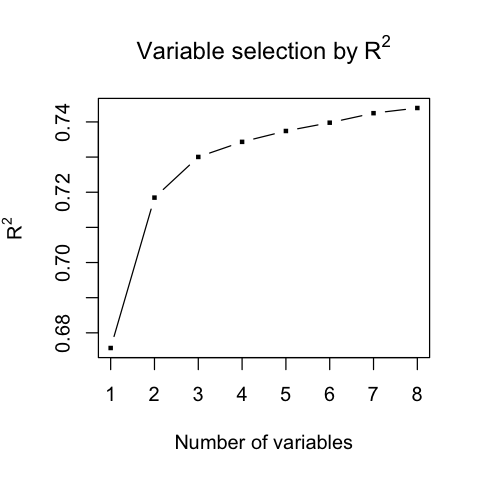

In [30]:
options(repr.plot.width=4, repr.plot.height=4)
plot(regsub.mat[,"r_square"],type="b",
     main=bquote("Variable selection by"~R^2),
     xlab="Number of variables",
     ylab=expression(R^2),
     cex=0.5,pch=15
)

We observe this plot and find that two or three variables has already explained the response well enough. Adding more features doesn't bring significant increases to R2
  and meanwhile make the model more complex. In other words, there's a tradeoff between the accuracy and complexity of the model. By R2
  criteria, we decide to keep the first two models, 
  
  i.e.
BODY$\sim$WEIGHT+ABDOMEN+WRIST and BODY$\sim$WEIGHT+ABDOMEN

## 2.2 Overview of 3 possible models
#### 2.2.1 BODY~WEIGHT+ABDOMEN

In [31]:
model1 = lm(BODYFAT~WEIGHT+ABDOMEN,data=bodyfat.dat)
summary(model1)


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN, data = bodyfat.dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1258  -2.9324  -0.1172   2.9706   9.8901 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -43.17751    2.50890 -17.210  < 2e-16 ***
WEIGHT       -0.12000    0.01975  -6.077 4.71e-09 ***
ABDOMEN       0.90424    0.05216  17.335  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.047 on 243 degrees of freedom
Multiple R-squared:  0.7185,	Adjusted R-squared:  0.7161 
F-statistic: 310.1 on 2 and 243 DF,  p-value: < 2.2e-16


#### 2.2.2  BODY~WEIGHT+ABDOMEN+WRIST

In [32]:
model2 = lm(BODYFAT~WEIGHT+ABDOMEN+WRIST,data=bodyfat.dat)
summary(model2)


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = bodyfat.dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.9532 -2.8752 -0.4071  2.9816  9.1751 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -24.39458    6.33055  -3.853 0.000149 ***
WEIGHT       -0.08407    0.02236  -3.759 0.000214 ***
ABDOMEN       0.88819    0.05143  17.271  < 2e-16 ***
WRIST        -1.30210    0.40431  -3.221 0.001455 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.971 on 242 degrees of freedom
Multiple R-squared:   0.73,	Adjusted R-squared:  0.7267 
F-statistic: 218.1 on 3 and 242 DF,  p-value: < 2.2e-16


#### 2.2.3 BODYFAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST

In [33]:
model3 = lm(BODYFAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST,data=bodyfat.dat)
summary(model3)


Call:
lm(formula = BODYFAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + 
    FOREARM + WRIST, data = bodyfat.dat)

Residuals:
   Min     1Q Median     3Q    Max 
-9.623 -2.903 -0.250  2.789  8.759 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.84904    7.78088   0.880  0.37962    
AGE          0.04833    0.02321   2.083  0.03836 *  
HEIGHT      -0.31413    0.11436  -2.747  0.00648 ** 
NECK        -0.32537    0.20376  -1.597  0.11163    
CHEST       -0.12950    0.08186  -1.582  0.11499    
ABDOMEN      0.81752    0.06039  13.537  < 2e-16 ***
FOREARM      0.32097    0.17753   1.808  0.07188 .  
WRIST       -1.49958    0.46003  -3.260  0.00128 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.911 on 238 degrees of freedom
Multiple R-squared:  0.7425,	Adjusted R-squared:  0.7349 
F-statistic: 98.03 on 7 and 238 DF,  p-value: < 2.2e-16


## 2.3 Cross Validation
We use k-fold cross validation to decide our final models. Here we chose k = 6 according to the reference. In (Jung, Y., 2017. Multiple predicting K-fold cross-validation for model selection. Journal of Nonparametric Statistics, pp.1-19.), the author suggests one empirical choice where $K\approx\log n$ and $n/K>3d$ where $d$ is the number of features.

In [34]:
library(caret)
set.seed(2019)
train_control <- trainControl(method="cv", number=6)
model1 <- train(BODYFAT~WEIGHT+ABDOMEN,data=bodyfat.dat,trControl=train_control,method="lm",metric="RMSE")
model2 <- train(BODYFAT~WEIGHT+ABDOMEN+WRIST,data=bodyfat.dat,trControl=train_control,method="lm",metric="RMSE")
model3<- train(BODYFAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST,data=bodyfat.dat,
               trControl=train_control,method="lm",metric="RMSE")

## 2.4 Final Model

In order to see the performance of each model, we see Root of Mean Squared Error(RMSE)$=\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(Y_{i}-\hat{Y}_{i}\right)^{2}}$. The RMSE of each model is shown below:

|Index| Model | RMSE |
|--|:----------------|:-----------------------------------------------------------------------|
|1|BODYFAT~WEIGHT+ABDOMEN|4.068086|
|2|BODYFAT~WEIGHT+ABDOMEN+WRIST|3.967418|
|3|BODYFAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+FOREARM+WRIST|3.946156|


We can see that the RMSE increases as the number of features decreases, but it doesn't change so much from model3 to model2: $\frac{3.967418-3.946156}{3.946156}=0.5\%$. Furthermore, we can see that in the third model there are 4 terms having p-value greater than 0.05. Therefore, based on the rule of thumb, we finally choose WEIGHT, ABDOMEN and WRIST to be the explanatory variables.

# 3 Regression Diagnosis

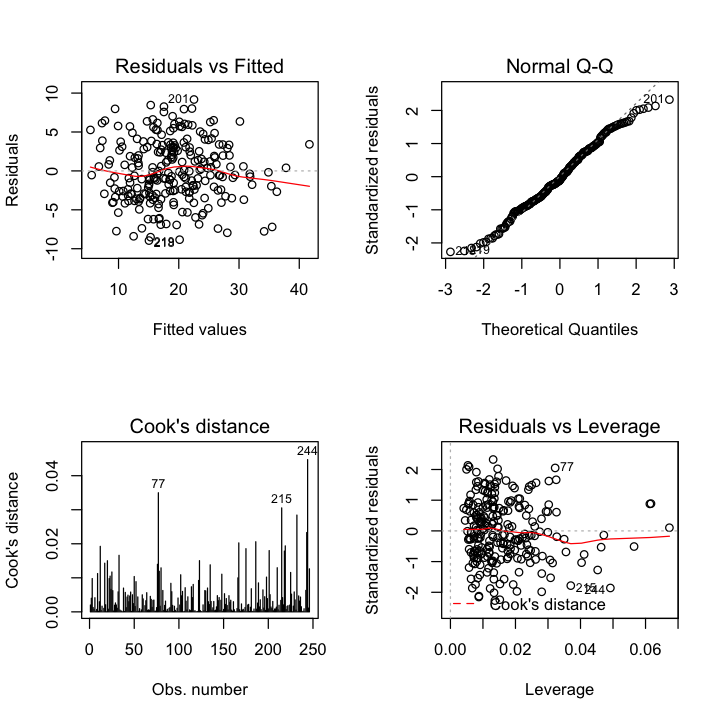

In [35]:
options(repr.plot.width=6, repr.plot.height=6)
final.model <- lm(BODYFAT~WEIGHT + ABDOMEN + WRIST,data=bodyfat.dat)
par(mfrow = c(2,2))
plot(final.model, which = c(1,2,4,5))

## 3.1 Independence and linearity
Assume independence holds as we collect the data on randomly chosen individual. We can see there is linear relationship between response and predictors from the plots below.

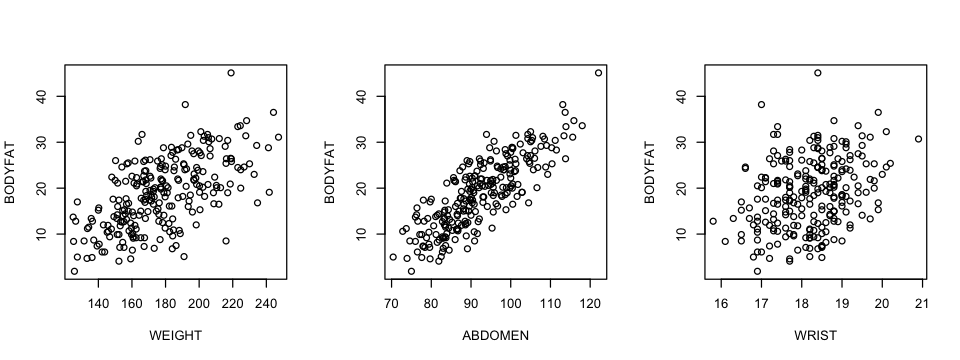

In [36]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow = c(1,3))
plot(BODYFAT ~ WEIGHT, data=bodyfat.dat)
plot(BODYFAT ~ ABDOMEN, data=bodyfat.dat)
plot(BODYFAT ~ WRIST, data=bodyfat.dat)

## 3.2 Normality
From residual plot, we can consider that there is no non-linear trend, and it has homoscedasticity.
Furthermore, since the response are positive, we can use boxcox to see whether we need a transformation.

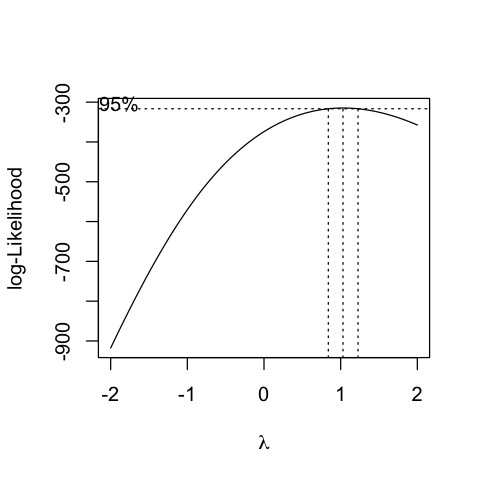

In [37]:
options(repr.plot.width=4, repr.plot.height=4)
MASS::boxcox(bodyfat.dat$BODYFAT ~ bodyfat.dat$WEIGHT+bodyfat.dat$ABDOMEN+bodyfat.dat$WRIST)

$\lambda=1$ is in the 95% confidence interval, so we don't need to do a transformation on y and the normality can be considered satisfied.

## 3.3 Outlier

In [38]:
sum(which(abs(rstudent(final.model))>2.576)) # 2.576 is the 0.01 quantial of N(0,1)

[1] 0

There is no point with Studentized residuals out of 1% quantile of a standard normal distribution, and furthermore no student no studentized residuals with Bonferroni p < 0.05.

## 3.4  High leverage point
With hatvalue greater than $2p/n$.

In [39]:
bodyfat.dat[unname(which(hatvalues(final.model)>2*4/dim(bodyfat.dat)[1])),c("BODYFAT","WEIGHT","ABDOMEN","WRIST")]

,BODYFAT,WEIGHT,ABDOMEN,WRIST
,<dbl>,<dbl>,<dbl>,<dbl>
9,5.1,191.00,82.5,18.2
12,8.5,216.00,90.9,19.0
35,31.1,247.25,115.6,19.7
36,38.2,191.75,113.1,17.0
108,21.6,178.25,95.0,19.8
147,19.1,241.75,102.9,19.6
173,28.8,241.25,110.3,18.4
199,33.4,223.00,113.9,17.4
210,45.1,219.00,122.1,18.4


In [40]:
summary(bodyfat.dat[c("WEIGHT","ABDOMEN","WRIST")])

     WEIGHT         ABDOMEN           WRIST     
 Min.   :125.0   Min.   : 70.40   Min.   :15.8  
 1st Qu.:159.4   1st Qu.: 85.22   1st Qu.:17.6  
 Median :176.5   Median : 90.95   Median :18.3  
 Mean   :178.1   Mean   : 92.36   Mean   :18.2  
 3rd Qu.:196.8   3rd Qu.: 99.17   3rd Qu.:18.8  
 Max.   :247.2   Max.   :122.10   Max.   :20.9  

Points with large hat value just mean that their predictors are farther from the center but doesn't mean they are abnomal. We just have a look at this point, but won't delete them. Specifically:

* Point 9 has weight close to the 3rd quantile but abdomen lower than the 1st quantile he should have a very strong body which we can also see from the bodyfat.

* Point 36 has weight close to the 1st quantile but abdomen higher than the 3rdquantile he should have a very fat body which we can also see from the bodyfat.

* Point 12, 35, 146, 172, 198, 209, 235, 245 have high weights.

* Point 214, 219, 241 have low weights.

* Point 107 has weight and abdomen close to mean, but wrist large than the 3rd quantile.

* Point 243 has weight and wrist close to mean, but abdomen large than the 3rd quantile.

## 3.5 High influencial point

In [41]:
sum(which(cooks.distance(final.model)>0.5))

[1] 0

There is no point with cook's distance larger than 0.5.

# 4 Interpretation of Model 
If you want to calculate you body fat percentage, you can multiply you weight(lbs)  with -0.08407, multiply your Abdomen 2 circumference (cm) with 0.88819, multiply your Wrist circumference (cm) with -1.30210, then add these three terms together and minus 24.39458.
# 5 Summary
We use a linear regression to predict the bodyfat where predictors includes Weight, Abdomen, Wrist.

Pros: Our model is simple, easy to understand and applied.

Cons: Our training data is from the 252 men aged 22-81, so the model may not be applicable to women or children.